# Pytorchifying Batch normalization 

In this nb we will use ready made classes from pytorch rather than writing custon NN layers with BN and activation. This is how it will be deployed in production. Lets get through some prerquisites though. 

1. [nn.linear](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
- To initialize a linear layer (Wx + b) with in_features, out_features, bais as parameters. In case applying BN, bias = Flase can be set. 
- Also see _how_ the weights and biases are initialized when nn.Linear() is called:<br>
Values are sampled from $U(-\sqrt{k},\sqrt{k})$, where $k = \frac{1}{in\_features}$ (uniformly) - note that this is similar to `kaiming init` without the gain factor $\frac{5}{3}$ for tanh! 


2. [nn.BatchNorm1d](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d1)
- Mathematically: $ y = \frac{x - \mathbb{E}[x]}{\sqrt{\text{Var}[x] + \varepsilon}} \cdot \gamma + \beta $, where $\gamma = $ bngain, $\beta = $ bnbias

Lets break down its arguments: <br>
- $\epsilon$ prevents blowing up around $0$
- `momentum` is the update rate for the `bnmeani` to update the running_mean ($\alpha$ in the previous files)
- `affine` must be true to ensure _bngain_ and _bnbias_ are learnable 
- `track_running_stats` allows computing overall mean, std etc while training itself. 



In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
allchars = sorted(set(''.join(words)))

stoi = {s:i+1 for i,s in enumerate(allchars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Lets make our network deeper and layers more generalizable unlike explicit definition for each layer. 

 The classes we create here are the same API as nn.Module in PyTorch

In [5]:
g = torch.Generator().manual_seed(200989800)

In [16]:
class Linear:

    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) * 1/fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        params = [self.weight] + ([] if self.bias is None else [self.bias])
        return params
    

class BatchNorm1d: 

    def __init__(self, size, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(size)
        self.beta = torch.zeros(size)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(size)
        self.running_var = torch.ones(size)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim = 0, keepdim = True)
            xvar = x.var(dim = 0, keepdim = True)

        else: 
            xmean = self.running_mean
            xvar = self.running_var
        # apply to data
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps)

        self.out = self.gamma * xhat + self.beta # gain * xhat + bias 
 
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var

        return self.out
    
    def parameters(self):
        return [self.gamma , self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [26]:
n_embed = 10
n_hidden = 100 

C = torch.randn((vocab_size, n_embed), generator=g)

layers1 = [
    Linear(n_embed*block_size , n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden), Tanh(), 
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident -- to avoid saturation to extremes for softmax
  layers1[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers1[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 #5/3

parameters = [C] + [p for layer in layers1 for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


__Note:__ that the last/ output layer, i.e. `layers[-1]` outputs raw logits for which, layers1(x) will undergo softmax.So the last layer is essentially just the softmax layer which we will skip in our histogram visualization step.  

In [35]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers1:
    x = layer(x)
  loss = nn.functional.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers1:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2678


## Visualization (without BN)

Lets try to visualize the values post activation after each of these layers so see if there is saturation of any sort. We have defined `t.abs() > 0.97` as the criteria for saturation below. 

__This allows us to diagnose the health of our Neural networks and answer some key questions - is my init corrrect? or gain? etc__

In [22]:
def tanh_saturation_hist(NN):
    plt.figure(figsize=(20,4))
    legends = []

    for i, layer in enumerate(NN[:-1]):  # skip last softmax layer 
        if isinstance(layer, Tanh):
            t = layer.out
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density = True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')


    plt.legend(legends);
    plt.title('activation distribution')
    return

layer 1 (      Tanh): mean -0.02, std 0.72, saturated: 16.19%
layer 3 (      Tanh): mean -0.03, std 0.67, saturated: 7.34%
layer 5 (      Tanh): mean +0.01, std 0.66, saturated: 5.81%
layer 7 (      Tanh): mean -0.01, std 0.65, saturated: 4.75%
layer 9 (      Tanh): mean +0.01, std 0.66, saturated: 5.91%


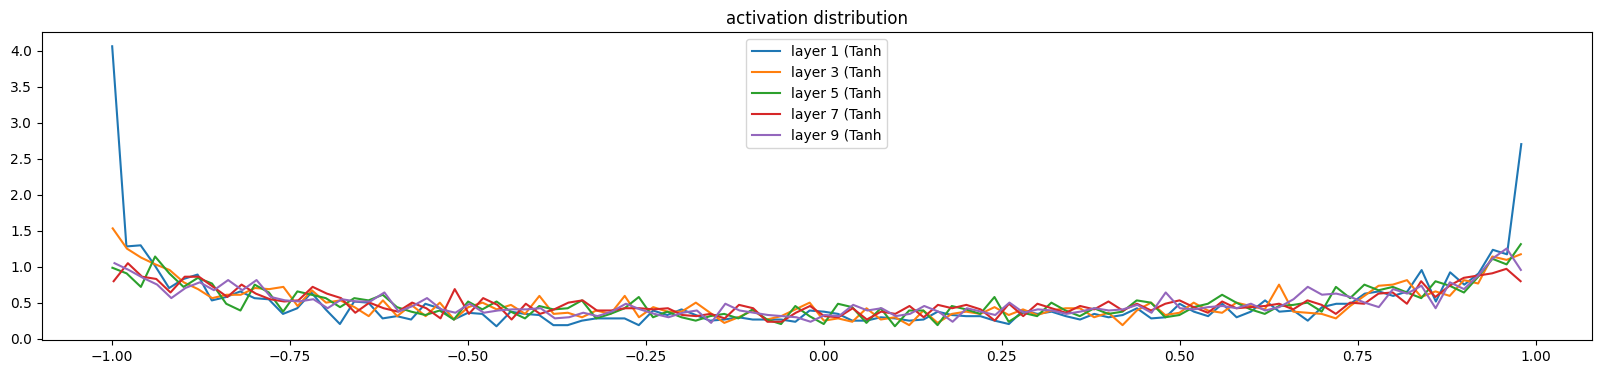

In [28]:
# visualize outputs of tanh - after 1 iteration
tanh_saturation_hist(layers1)

There are two crucial reasons for low saturation levels at init as indicated by the above plot: 

1. `1/fan_in**0.5` factor is added by default in `class Linear` during init
2. This snippet of code after defining layers1:
```
with torch.no_grad():
...
    if isinstance(layer, Linear):
      layer.weight *= 5/3
```
the gain factor of $\frac{5}{3}$ is also very cruical!


### Why is gain of 5/3 crucial?

- In a sequence of Linear layers and Tanh without gain, the Tanh will keep squashing the inputs between $-1$ and $1$ and std dev will decrease with every subsequent layer. 
- So 5/3 expansion factor prevents introduces space before squashing!
- Look below for situation without gain of $\frac{5}{3}:$
- However, gain cant be too large (3 or so) else the saturation will still persist. 

layer 1 (      Tanh): mean +0.03, std 0.62, saturated: 4.28%
layer 3 (      Tanh): mean -0.01, std 0.53, saturated: 0.69%
layer 5 (      Tanh): mean +0.00, std 0.50, saturated: 0.16%
layer 7 (      Tanh): mean -0.05, std 0.52, saturated: 0.16%
layer 9 (      Tanh): mean +0.00, std 0.54, saturated: 0.28%


Text(0.5, 1.0, 'activation distribution')

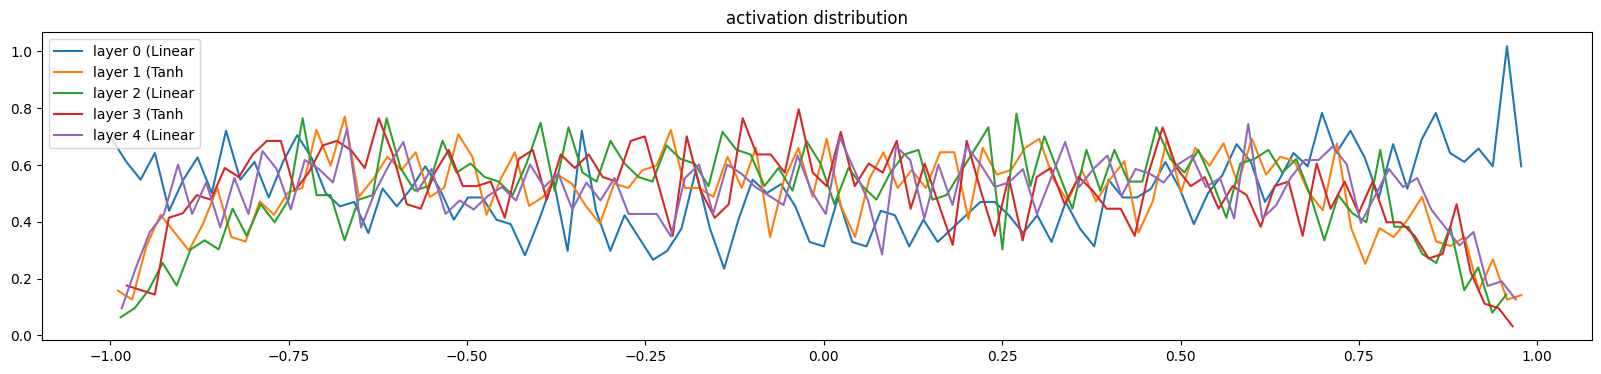

In [ ]:
# with no gain or gain = 1 - - after 1 iteration

## Plotting gradients 

So we're asking:

“How large are the gradients coming out of each Tanh layer, and how are they distributed?”
Because if gradients:
- Become very small (near zero) as we go backward → they vanish → earlier layers never learn anything.
- Become very large (exploding) → training becomes unstable.

__So the gradient distributions tell us if learning is healthy, or dying.__

### Interpretations:
1. A wide, centered distribution (e.g., mean near 0, standard deviation around 0.01 to 1) → gradients are flowing well. Good!
2. A very narrow distribution (e.g., centered at 0, with std ~ 1e-6 or less) → gradients have vanished. Earlier layers will barely update.
3. A very wide distribution (e.g., std ~ 100+) → gradients are exploding, causing chaotic updates. Unstable training.

### Why Do Gradients Vanish or Explode?
- Each Tanh squashes its input into [-1, 1], so its derivative is small unless input is near 0.

- With many Tanh layers stacked, the chain rule multiplies those small derivatives → gradients get smaller and smaller → vanish.

- If weight initialization is too large, the opposite can happen → exploding gradients.

In [44]:
def tanh_grad_hist(NN):
  plt.figure(figsize=(20, 4)) # width and height of the plot
  legends = []
  for i, layer in enumerate(NN[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
      t = layer.out.grad
      print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
      hy, hx = torch.histogram(t, density=True)
      plt.plot(hx[:-1].detach(), hy.detach())
      legends.append(f'layer {i} ({layer.__class__.__name__}')
  plt.legend(legends);
  plt.title('gradient distribution')
  return

layer 1 (      Tanh): mean -0.000006, std 4.337622e-04
layer 3 (      Tanh): mean +0.000015, std 3.981613e-04
layer 5 (      Tanh): mean -0.000001, std 3.791831e-04
layer 7 (      Tanh): mean +0.000010, std 3.511105e-04
layer 9 (      Tanh): mean -0.000002, std 3.166271e-04


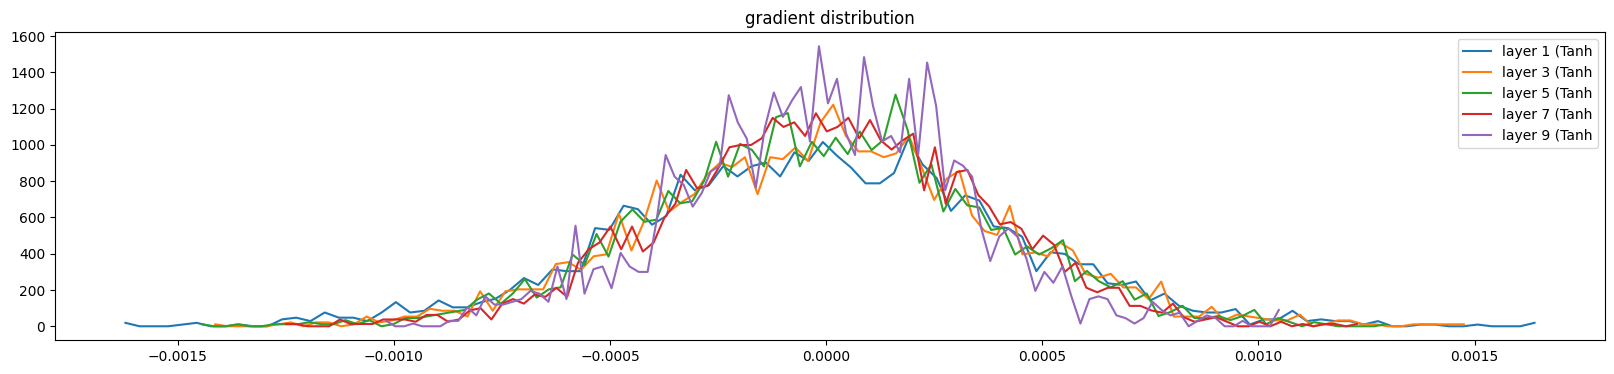

In [30]:
# gradient plots to see about health of learning across layers - after 1 iteration
tanh_grad_hist(layers1)

__Exercise:__ Can change gain to 3 or 0.2 (extremely high or low) and see how gradient values become unstable or too low post tanh layer.

In case of absence of Tanh() leayer and only linear layer:
1. It is a fancy linear regression after all 
2. gain of 1 must be used for linear layers, not 5/3 [as per this](https://docs.pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain), to get stable results. 

<span style="color:#FF0000; font-family: 'Bebas Neue'; font-size: 01em;">NOTE:</span>
Without activation a multiple Linear layers get sandwiched as an equivalent single Linear layer, during forward pass. But the complexiety introduced by backprop and grad calculation adds to extra elements! Some papers on $\infty$ linear layers being stacked etc. 

In [33]:
def grad_to_data_hist():
  plt.figure(figsize=(20, 4)) # width and height of the plot
  legends = []
  for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # to only plot weights, which has ndim = 2
      print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
      hy, hx = torch.histogram(t, density=True)
      plt.plot(hx[:-1].detach(), hy.detach())
      legends.append(f'{i} {tuple(p.shape)}')
  plt.legend(legends)
  plt.title('weights gradient distribution');
  return

weight   (27, 10) | mean -0.000493 | std 1.272978e-02 | grad:data ratio 1.328342e-02
weight  (30, 100) | mean +0.000075 | std 1.040309e-02 | grad:data ratio 3.418911e-02
weight (100, 100) | mean +0.000050 | std 8.012448e-03 | grad:data ratio 4.747722e-02
weight (100, 100) | mean -0.000099 | std 6.872527e-03 | grad:data ratio 4.106633e-02
weight (100, 100) | mean +0.000054 | std 6.443717e-03 | grad:data ratio 3.907896e-02
weight (100, 100) | mean +0.000099 | std 5.422666e-03 | grad:data ratio 3.187260e-02
weight  (100, 27) | mean +0.000000 | std 2.239479e-02 | grad:data ratio 3.311399e-01


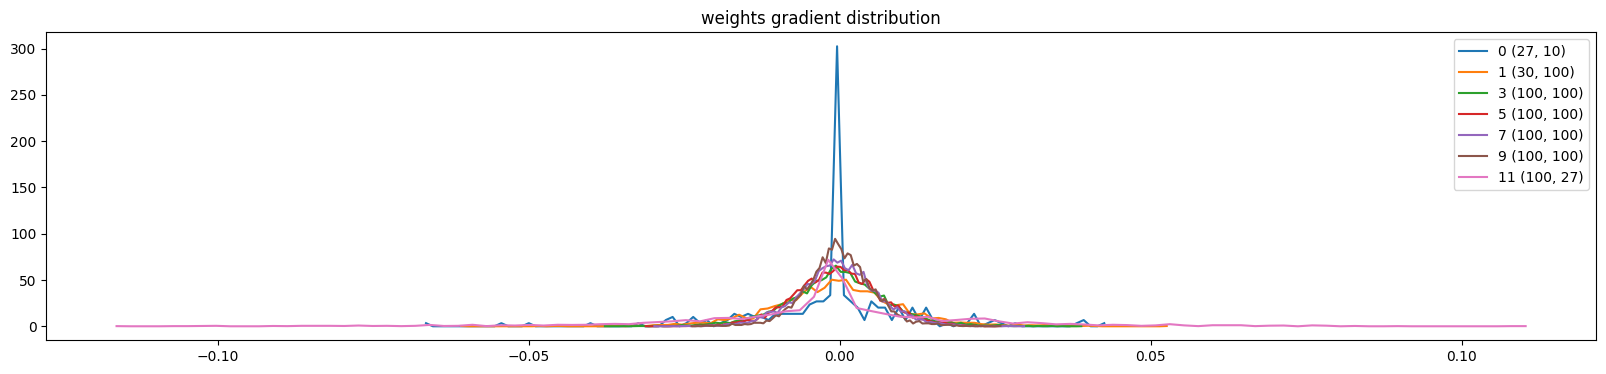

In [36]:
# gradient to data ratio to see if update speed will be ok -- at 1000 iterations
grad_to_data_hist()

The pink line (the last layer) is the outlier as the `grad:data ratio 2.471186e+00` is almost $100\times$ the other layers. Why?
__Because__ we had shrunk down the last layer output by 0.1 times during init to get _better_ softmax values. 

^This changes and auto corrects as we train the NN for more iterations. 

Rather than `grad:data` ratio, a `step:data` (step = grad*lr) is more revealing: 

In [39]:
def step_to_data():
  plt.figure(figsize=(20, 4))
  legends = []
  for i,p in enumerate(parameters):
    if p.ndim == 2:
      plt.plot([ud[j][i] for j in range(len(ud))])
      legends.append('param %d' % i)
  plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
  plt.legend(legends);

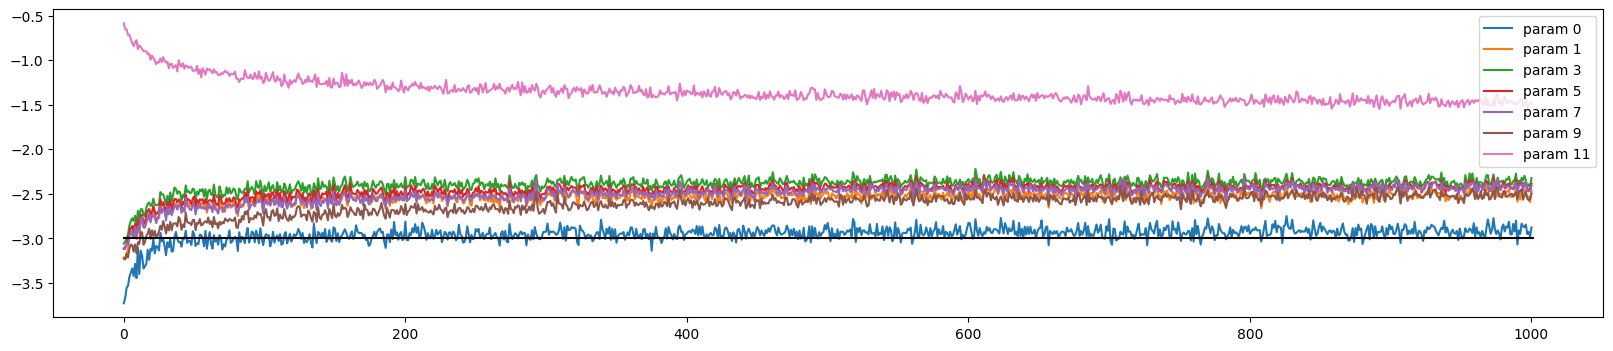

In [40]:
# step size : data variation across iterations -- run for 1000 iterations
step_to_data()

The pink line (last layer) has a higher $\lambda = $ `step:data` ratio since during init we had artifically compressed values by 0.1. 

For all other layers $\lambda = $`1e-3.log10() = -3` is a good benchmark. i.e. every step being 0.001 times the data value during SGD updates is a good range. 
- If $\lambda << -3$ , then weights are not updating fast enough, and we could benefit from a higher learning rate. 
- And similarly updates could be too unstable if $\lambda$ is too high. 

## Adding Backnorm and studying plots:

In [41]:
n_embed = 10
n_hidden = 100 

C = torch.randn((vocab_size, n_embed), generator=g)

layers_withbn = [
    Linear(n_embed*block_size , n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  # last layer: make less confident -- to avoid saturation to extremes for softmax
  layers_withbn[-1].gamma *= 0.1 
  # all other layers: apply gain
  for layer in layers_withbn[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 #5/3

parameters = [C] + [p for layer in layers_withbn for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


Training loop same as before:

In [42]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers_withbn:
    x = layer(x)
  loss = nn.functional.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers_withbn:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3266


Adding a batchnorm layer `BatchNorm1d(n_hidden)` is done after linear layer before activation (obv). It can also be added after the final linear layer before softmax, as as is the case above in `layers_withbn`.

We will train the network using the same training loop as above, for 1000 iterations and study the same plots as earlier: 

layer 2 (      Tanh): mean +0.01, std 0.62, saturated: 3.62%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.72%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.50%
layer 11 (      Tanh): mean +0.01, std 0.65, saturated: 1.84%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


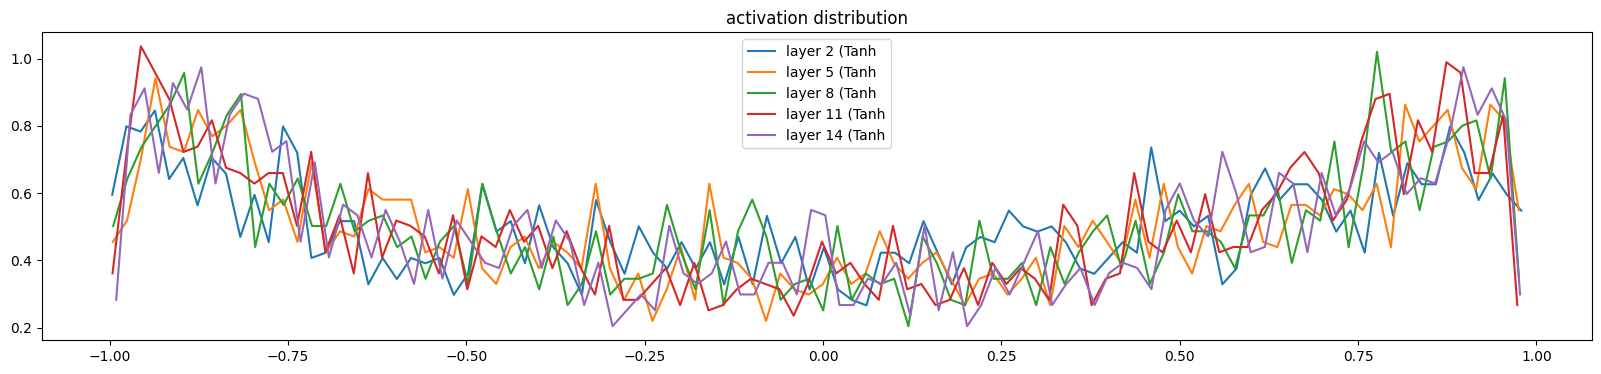

In [46]:
# at 1000 iterations
tanh_saturation_hist(layers_withbn)

layer 2 (      Tanh): mean +0.000000, std 3.504749e-03
layer 5 (      Tanh): mean +0.000000, std 3.155784e-03
layer 8 (      Tanh): mean -0.000000, std 2.760225e-03
layer 11 (      Tanh): mean -0.000000, std 2.593701e-03
layer 14 (      Tanh): mean +0.000000, std 2.571775e-03


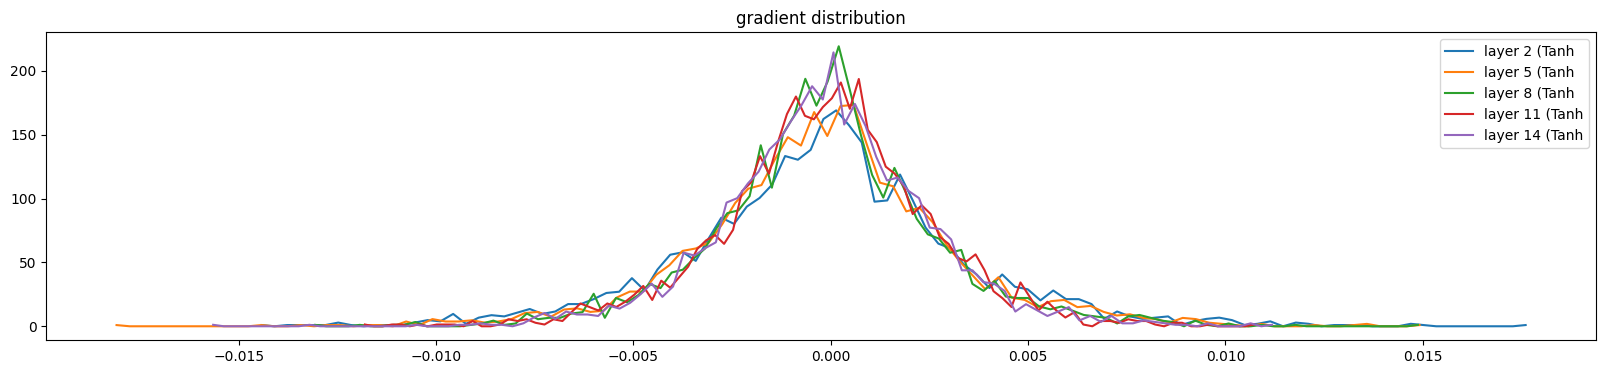

In [ ]:
# at 1000 iterations
tanh_grad_hist(layers_withbn)

weight   (27, 10) | mean +0.000000 | std 8.236405e-03 | grad:data ratio 8.080543e-03
weight  (30, 100) | mean -0.000005 | std 7.205395e-03 | grad:data ratio 2.311134e-02
weight (100, 100) | mean -0.000056 | std 6.489568e-03 | grad:data ratio 3.853715e-02
weight (100, 100) | mean +0.000072 | std 5.732962e-03 | grad:data ratio 3.464818e-02
weight (100, 100) | mean +0.000026 | std 4.887551e-03 | grad:data ratio 2.950026e-02
weight (100, 100) | mean +0.000057 | std 4.698596e-03 | grad:data ratio 2.827078e-02
weight  (100, 27) | mean +0.000025 | std 9.357362e-03 | grad:data ratio 5.648346e-02


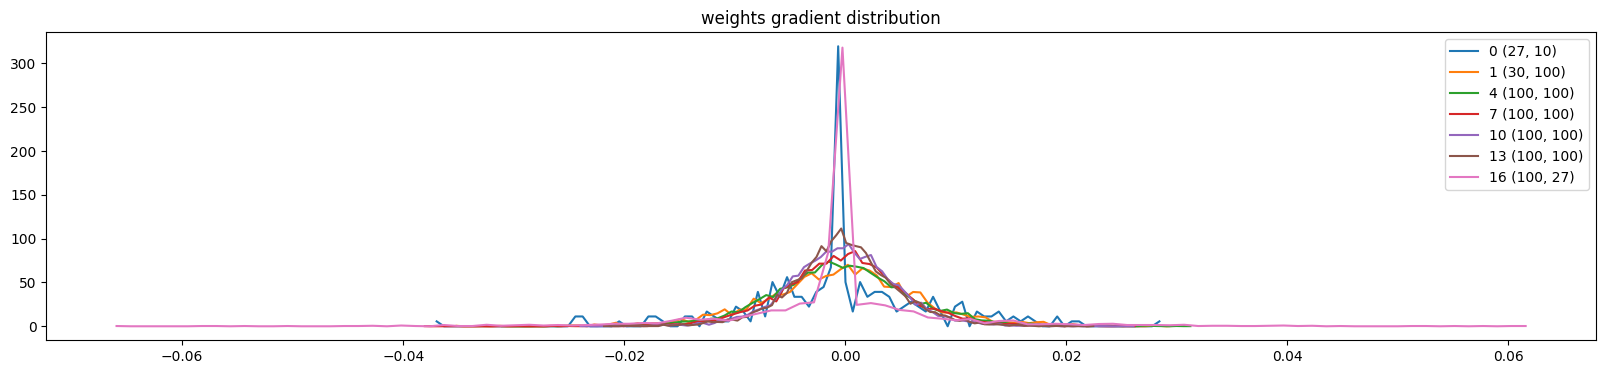

In [49]:
# at 1000 iterations
grad_to_data_hist()

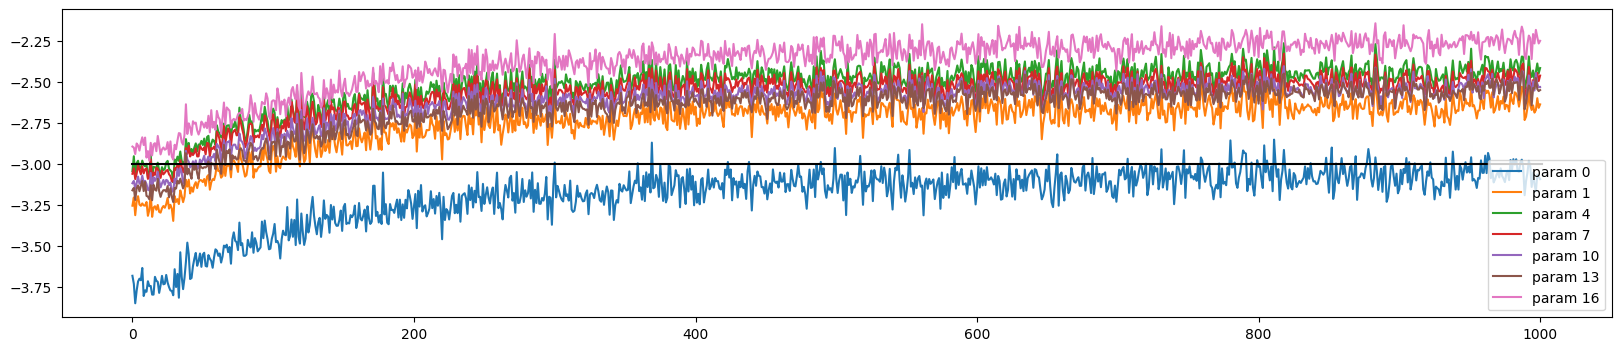

In [50]:
# at 1000 iterations
step_to_data()

### Conclusion: (with batchnorm)

The addition of batch norm layer has nullified the impact of gain; now gain can have any value and Tanh layer outputs and their gradients will always be stable. 

The only key impact of a good gain value will be visible in $\lambda = $ `step:data` ratio! So that we may have to experiment a bit to ensure $\lambda = $ `step:data.log10()` stays around $-3$ and updates are not too fast or too slow!